# Импорты

In [ ]:
# from langchain_gigachat import GigaChat
from langgraph.graph import MessagesState
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
# from langchain.chat_models import ChatOpenAI
import os
from dotenv import load_dotenv

# Загружаем переменные окружения из .env файла
load_dotenv()

# Получаем API-ключ из переменной окружения
creds = os.getenv('credentials')
token = os.getenv('OPENAI_API_KEY')

# Моки сценариев и функций

In [17]:
rag_return_scenario = ["""
Сценарий определения погоды:
1) Определи, где пользователь хочет узнать погоду.
2) Определи погоду в данной местности и сообщи пользователю результат.
""",
# """Сценарий потери банковской карты:
# Если пользователь потерял или сломал банковскую карту, есть 4 основных этапа:
# 1) Определи, какие у пользователя есть карты. (например у пользователя есть следующие карты ***1234, ***2345 или ***3456)
# 2) Предложи заблокировать эту карту.
# 3) Предложи пользователю перевыпустить карту. (например перевыпустить на карту Momentum либо на карту постоянного пользования)
# 4) Предложи пользователю доставить карту. (например с помощью сервиса доставки "Самокат" либо самовывозом)""",
"""
Сценарий перевода денежных средств на другую карту пользователя (перевод самому себе):
1) Определи, какие у пользователя есть карты. (например у пользователя есть следующие карты ***9876, ***5432 или ***1098).
2) Узнай у пользователя с какой карты и на какую карту он хочет перевести деньги.
3) Убедись, что у пользователя есть необходимое количество средств, в случае успеха получи от пользователя подтверждение на перевод, в случае недостатка средств сообщи об этом пользователю.
4) Сделай перевод и уведоми об этом пользователя.
""",
]
rag_return_func = """Для выполнения задачи у тебя есть следующие функции:
- `get_user_cards()`: Функция для возврата списка имеющихся у пользователя карт.
- `block_card()`: Функция для блокировки карты.
- `reissue_card()`: Функция для перевыпуска карты.
- `deliver_card()`: Функция для доставки карты пользователю.
- `card_balance()`: Функция для определения баланса на карте.
- `transefer_money()`: Функция для перевода денег с карты на карту.
- `destination_weather()`: Функция для определения погоды в конкретной местности.
"""

In [18]:
from typing import Annotated, List, Tuple, Union, Literal, Dict
from typing_extensions import TypedDict
from pydantic import BaseModel, Field


class Plan(BaseModel):
    """План по которому будет действовать агент-исполнитель"""
    steps: List[str] = Field(
        description="Шаги, которые должны быть выполнены. Каждый этап начинается с цифры и скобки, например, '1) первый этап'."
    )

In [19]:
# Нужно будет придумать логику бинда функций для разных задач, мы же не будем биндить сразу все доступные функции

# Set up the tool
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

@tool
def get_user_cards(cards_name: str):
    """Выдаёт пользователю список карт, которые у него есть."""
    cards_name = ['***1234', '***2345','***3456']
    # Логика для получения списка карт пользователя через API или другой механизм.У пользователя есть следующие карты ***1234, ***2345 или ***3456
    return f'Список доступных карт: {cards_name}'

@tool
def block_card(card_name: str):
    """Заблокировать карту"""
    # Логика для блокировки карты через API или другой механизм
    return f"Карта {card_name} успешно заблокирована."

@tool
def reissue_card(card_name: str, new_card_type: str = "Momentum"):
    """Перевыпустить карту. Например, можно выбрать карту типа Momentum или карту постоянного пользования."""
    # Логика перевыпуска карты
    return f"Перевыпущена карта типа {new_card_type}."

@tool
def deliver_card(delivery_method: str = "Самокат"):
    """Организовать доставку карты. Можно выбрать способ доставки: 'Самокат' или самовывоз."""
    if delivery_method.lower() == "самокат":
        return "Карта будет доставлена с помощью службы доставки 'Самокат'."
    elif delivery_method.lower() == "самовывоз":
        return "Вы можете забрать карту в пункте самовывоза."
    else:
        return "Выберите один из доступных методов доставки: 'Самокат' или 'Самовывоз'."
    
@tool
def card_balance(card_name: str, balance):
    """Узнать баланс на карте"""
    # Логика для получения баланса карты через API или другой механизм
    return f"На карте {card_name} есть {balance} средств."

@tool
def transefer_money(card_name: str, card_name_to: str, balance):
    """Перевести деньги с карты на карту"""
    # Логика для перевода денег с карты на карту через API или другой механизм
    return f"Переведено {balance} с  карты {card_name} на карту {card_name_to}."

@tool
def destination_weather(destinatio: str):
    """Определение погоды в данной местности"""
    # Логика для определения погоды в данной местности через API или другой механизм
    return f"В {destinatio} следующая погода."

tools = [get_user_cards, block_card, reissue_card, deliver_card, card_balance, transefer_money, destination_weather]
tool_node = ToolNode(tools)
memory = MemorySaver()


# Промпты

In [25]:
# prompts and models
from langchain_core.prompts import ChatPromptTemplate

# планнер сценарный
planner_template = """
Ты — агент-планировщик. Твоя задача — разработать подробный и последовательный план действий для решения проблемы, исходя из предоставленного сценария и доступных функций. План будет передан агенту-исполнителю для выполнения.

Задание:
Тебе нужно создать план, основываясь на самых релевантных для запроса пользователя сценариях и списке доступных функций.

Сценарии: {scenario}

Функции: {functions}

Диалог c пользователем: {messages}

Твой план должен соответствовать следующим требованиям:
1. **Разработай последовательность шагов**, которая максимально эффективно решает проблему, учитывая сценарий и доступные функции.
2. **Определи возможные пробелы** в информации, которые могут потребовать уточнения от пользователя, и составь план так, чтобы на важных этапах ты мог запросить дополнительные разъяснения.
3. **Запроси разрешение** у пользователя на выполнение критичных операций, таких как изменение данных или выполнение действий, которые могут повлиять на дальнейшие шаги.
4. Учитывай, что **агент-исполнитель будет подробно описывать каждый шаг**, который он будет выполнять, а также будет указывать, какие функции использует на каждом этапе. Поэтому убедись, что каждый этап описан максимально четко.
5. Если какие-то шаги требуют предварительных условий или зависимостей, укажи это.

**Итоговый формат плана:**
Составь список шагов в следующем формате:
1) Описание первого шага: конкретное действие, использованные функции, возможные уточнения.
2) Описание второго шага: конкретное действие, использованные функции, возможные уточнения.
3) Описание третьего шага: конкретное действие, использованные функции, возможные уточнения.
... и так далее.

В конце каждый шаг должен быть записан в формате: "N) описание шага".

Убедись, что план логичен, последовательный и детализированный.
"""
planner_prompt = ChatPromptTemplate.from_template(planner_template)

planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan, include_raw=True)

#грейдер оценка по плану\нет
class GradePlan(BaseModel):
    """Релевантен ли запрос текущему плану"""

    binary_score: Literal["yes", "no"] = Field(
        ...,
        description="Релевантен ли запрос плану yes или no",
    )


grader_prompt = """ Ты оцениваешь релевантность запроса пользователя по отношению к текущему плану в два этапа:

Этап 1: Оценка релевантности запроса текущему плану
Проанализируй запрос пользователя в контексте текущего плана. Если запрос содержит информацию, связанную с этим планом (например, этапы, задачи или темы, упомянутые в плане), оцени его как релевантный (yes).
Обрати внимание, что пользователь может уже пройти часть плана, поэтому внимательно проверь соответствие запроса каждому этапу.
Дай бинарную оценку:

yes — запрос релевантен текущему плану
no — запрос не связан с текущим планом
Не возвращай итоговый ответ на данном этапе, сперва пройди этап 2.

Диалог с пользователем:
(Основное внимание удели последним репликам пользователя)
{messages}

Текущий план:
{plan}

Этап 2: Проверка на более релевантный сценарий
Если на первом этапе ты дал ответ "yes", то проверь, есть ли более релевантный сценарий среди предзагруженных сценариев. Если такой сценарий найден, верни "no". Если связанного сценария нет, оставь ответ "yes".

Предзагруженные сценарии:
{rag_return_scenario}

Пример 1:
Первый этап:
Диалог с пользователем: 
humanmessage: потерял сумку
aimessage: Мне очень жаль слышать, что вы потеряли сумку. Можете, пожалуйста, сообщить, когда и где именно вы ее потеряли? Эта информация поможет мне понять, возможно ли вернуть сумку.
humanmessage: в ней была карта
Текущий план:
1) Запросить у пользователя информацию о сумку: когда и где он ее потерял, чтобы понять, возможно ли ее найти или вернуть.
2) Уточнить, есть ли у пользователя возможность обратиться в место, где он потерял сумку (например, в магазин, кафе и т.д.), и предложить помощь в этом.
3) Если сумка была потеряна в общественном месте, предложить пользователю обратиться в службу находок или в полицию, если это необходимо.
4) Обсудить возможность покупки новой сумки, если старая не найдется, и предложить варианты, если пользователь заинтересован.
Результат первого этапа: yes. Так как диалог связан с текущим планом
Второй этап: 
Предзагруженные сценарии:
["Сценарий потери карты:
Если пользователь потерял или сломал карту, есть 4 основных этапа:
1) Определи, о какой карте идет речь. (например у пользователя есть следующие карты ***1234, ***2345 или ***3456)
2) Предложи заблокировать эту карту.
3) Предложи пользователю перевыпустить карту. (например перевыпустить на карту Momentum либо на карту постоянного пользования)
4) Предложи пользователю доставить карту. (например с помощью сервиса доставки 'Самокат' либо самовывозом)"]
Результат второго этапа: no. Так как нашёлся более релевантный сценарий "потеря карты". Оценка по предзагруженным сценариям всегда в приоритете.
Итоговый ответ: no
"""
planner_grader_prompt = ChatPromptTemplate.from_template(grader_prompt)

planner_grader = planner_grader_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(GradePlan, include_raw=True)

#грейдер оценка есть ли сценарий для формирования первичного плана
class GradeScenario(BaseModel):
    """Есть ли релевантный сценарий для данного запроса"""

    binary_score: Literal["yes", "no"] = Field(
        ...,
        description="Релевантен ли запрос какому-либо сценарию yes или no",
    )

grader_scen_prompt = """
Задача: Ты оцениваешь есть ли релевантный сценарий для данного запроса пользователя.

Проанализируй предоставленные сценарии и запрос пользователя. Если запрос содержит информацию, связанную с каким-то из предоставленных сценариев, оцени его как релевантный (yes).
Дай бинарную оценку:

yes — для данного запроса есть релевантый сценарий
no — для данного запроса нет релевантного сценария

Предзагруженные сценарии:
{rag_return_scenario}

Запрос пользователя:
{messages}
"""

planner_grade_scen_prompt = ChatPromptTemplate.from_template(grader_scen_prompt)

planner_scen_grader = planner_grade_scen_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(GradeScenario, include_raw=True)

# grader выполнен план или нет
class GraderCompletion(BaseModel):
    """Оценка завершённости плана"""

    completion_score: Literal['0', '1', '2'] = Field(
        ...,
        description="Оценка завершённости плана: '0' — не завершён, '1' — завершён, '2' — неактуален(пользователь передумал либо отказался)"
    )

completion_grader_prompt = """
Ты — агент, оценивающий завершенность текущего плана.

Задание:
Твоя задача — проанализировать текущий план и определить его степень завершенности. Для этого оцени, насколько полностью выполнены все этапы плана, и выбери одно из следующих значений:

0) План не завершён — еще есть этапы, которые нужно выполнить.
1) План завершён — все этапы выполнены, план завершен.
2) План неактуален — пользователь передумал либо отказался.

Внимание:
Основываясь на текущем плане и диалоге с пользователем оценить завершённость плана. Убедись, что твоя оценка точно отражает текущее состояние.

Текущий план:
{plan}
Диалог с пользователем:
{messages}

Оценка завершенности плана (выбери один из вариантов: '0', '1' или '2'): 
"""

completion_status_prompt_template = ChatPromptTemplate.from_template(completion_grader_prompt)

completion_status_agent = completion_status_prompt_template | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(GraderCompletion, include_raw=True)

# динамический планер
replanner_template = """
Задача: Ты — агент-планировщик. Твоя задача — разработать последовательный и детализированный план действий на основе текущей потребности пользователя и уже существующих планов, функций.

Информация для работы:
Диалог с пользователем (в приоритете для составления плана должны быть последние сообщения именно от пользователя):
{messages}
Предзагруженные планы (приоритетные планы, если они подходят):
{pred_plans}
Доступные тебе функции:
{functions}
Все планы (включая не приоритетные):
{all_plans}

Основные указания:
1. Проверь текущие планы: Прежде чем составлять новый план, проверь, может ли быть использован один из уже существующих планов. Рассматривай предзагруженные планы в первую очередь.
2. Если можно использовать уже сущестующий план просто верни его без изменений. Если подходящего готового плана нет начинай выполнение следующих указаний.
3. Действуй по текущей потребности: Составь план, который решает исключительно текущую потребность пользователя (то есть самую последнюю).
4. Запрашивай уточнения: Если для выполнения плана необходимы дополнительные уточнения от пользователя, укажи это на соответствующих этапах.
5. Согласовывай критичные операции: Если шаги плана предполагают изменения данных или выполнения действий, которые могут повлиять на другие этапы или информацию пользователя, обязательно запроси разрешение.
6. Четкость и последовательность: Каждый шаг должен быть максимально четким и подробным, чтобы агент-исполнитель мог выполнить его без дополнительных разъяснений.
7. Учитывай зависимости и предварительные условия: Если некоторые шаги зависят от других условий или требуют выполнения заранее, обязательно укажи это.

Формат итогового плана:
1) Описание действия, используемые функции, возможные уточнения.
2) Описание действия, используемые функции, возможные уточнения.
3) Описание действия, используемые функции, возможные уточнения.
И так далее.
Каждый шаг должен быть записан в формате:
N) Описание шага: конкретное действие, используемые функции, возможные уточнения.

Особенности:

На общие фразы (например, «привет», «пока», «как дела», «как настроение») не нужно создавать большие планы. В таких случаях достаточно вернуть план типа: «Просто болтай с пользователем».
План должен быть логичным, последовательным и детализированным.
"""

replanner_prompt = ChatPromptTemplate.from_template(replanner_template)

replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan, include_raw=True)

In [21]:
# экзекьютор
from langchain_core.runnables import RunnablePassthrough
def get_executor(plan):
    executor_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", f"""Ты — эмпатичный агент-исполнитель. Твоя задача — выполнить план действий, который ты получил от агента-планировщика. Следуй по плану, при этом уточняй информацию или предпринимай дополнительные шаги, если это необходимо.
    План:
    {plan}
    В процессе выполнения задач, если на каком-то этапе тебе не хватает информации или неясности по действиям, уточни их у пользователя.
    Пожалуйста, начни выполнение задач, следуя указанному плану. В конце своего ответа добавь "SYS": и опиши какой этап плана ты только что выполнил, также опиши свои действия (например какие функции ты использовал) и что ты будешь делать дальше.
    Информацию о функциях можно передавать только после SYS.
    """),
            ("human", "{input}"),
        ]
    )
    model = ChatOpenAI(model="gpt-4o-mini")
    model = model.bind_tools(tools, parallel_tool_calls=False)
    chain = {"input": RunnablePassthrough()} | executor_prompt | model
    return chain

# Граф

In [22]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage

# ОЦЕНКУ ПЛАНА ПОКА УБИРАЮ только токены пока ест закоменченный снизу код это для него + ноутбук state5

# class ComplexState(TypedDict):
#     plan: Tuple[List[str],str]
#     all_plans: List[Union[Tuple[List[str], int], List[str]]]
#     pred_plans: Tuple[List[str],str]
#     messages: Annotated[list[HumanMessage | AIMessage | ToolMessage], add_messages]

class ComplexState(TypedDict):
    plan: List[str]
    all_plans: List[List[str]]
    pred_plans: List[List[str]]
    messages: Annotated[list[HumanMessage | AIMessage | ToolMessage], add_messages]
    vremya_dengi: dict[str,str]

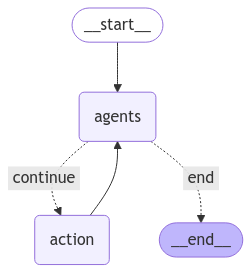

In [28]:
import time
import re
# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

# Define the function that calls the all models
def call_model(state):
    # print('state_begin')
    start_time = time.time()
    print(state)
    # print('----------')
    pred_plans = state.get("pred_plans")
    all_plans = state.get("all_plans")
    plan = state.get("plan")
    messages = state.get("messages")
    tokens = 0
    if plan is None:  # Check if plan is empty
        # print('1')
        pred_plans = []
        # логика старта посмотри в сценариях если есть схожие
        score_scen = planner_scen_grader.invoke({"rag_return_scenario": rag_return_scenario, "messages": state['messages']})
        # tokens+=score_scen.usage_metadata['total_tokens']
        tokens+=score_scen['raw'].response_metadata['token_usage']['total_tokens']
        if score_scen['parsed'].binary_score == 'yes':

            # print('rag')
            # global ps
            plan_pr = planner.invoke({"scenario": rag_return_scenario, "functions": rag_return_func, "messages": state['messages']})
            # ps = plan_pr
            tokens+=plan_pr['raw'].response_metadata['token_usage']['total_tokens']
            pred_plans.append(plan_pr['parsed'].steps)
            plan = plan_pr['parsed'].steps
        else: 
            # print('nerag')
            plan = replanner.invoke({"messages":messages,"pred_plans":pred_plans, "all_plans":all_plans, 'functions':rag_return_func})
            tokens+=plan['raw'].response_metadata['token_usage']['total_tokens']
            plan = plan['parsed'].steps
        
        print('---Первичный план--')
        print("\n".join(plan))
        print('----------')
        state['plan'] = plan
        # print(all_plans)
        chain = get_executor(plan=plan)
        
        response = chain.invoke(messages)
        end_time = time.time()
        total_time = end_time - start_time
        tokens+= response.usage_metadata['total_tokens']
        vremya_dengi = {'time':total_time,'tokens':tokens}
        response = AIMessage(content=response.content, tool_calls=response.tool_calls)
        return {"messages": [response],'plan':plan, 'all_plans':all_plans, "pred_plans":pred_plans, 'vremya_dengi':vremya_dengi}
    else:
        # print('2')
        score_plan_grade = planner_grader.invoke({"plan":plan,"rag_return_scenario":rag_return_scenario,"messages":messages[-1]})
        tokens+= score_plan_grade['raw'].response_metadata['token_usage']['total_tokens']
        if score_plan_grade['parsed'].binary_score == 'yes': #по плану
            print('po plany')
            plan = state['plan']
            # print(state['pred_plans'])
            print('---Текущий план--')
            print(plan)
            print("\n".join(plan))
            print('----------')
            chain = get_executor(plan=plan)
            response = chain.invoke(messages)
            end_time = time.time()
            total_time = end_time - start_time
            tokens+= response.usage_metadata['total_tokens']
            vremya_dengi = {'time':total_time,'tokens':tokens}
            # print('state_end_yes')
            # print(state)
            # print('----------')
            response = AIMessage(content=response.content, tool_calls=response.tool_calls)
            # print(state['messages'])
            return {"messages": [response],'plan':plan, 'all_plans':all_plans, "pred_plans":pred_plans, 'vremya_dengi':vremya_dengi}
        else: #не по плану
            print('ne po plany')
            score_scen_2 = planner_scen_grader.invoke({"rag_return_scenario": rag_return_scenario, "messages": state['messages'][-1]})
            tokens+= score_scen_2['raw'].response_metadata['token_usage']['total_tokens']
            print(state['messages'][-1])
            if score_scen_2['parsed'].binary_score == 'yes':
                print('rag ne po plany')
                plan_pr = planner.invoke({"scenario": rag_return_scenario, "functions": rag_return_func, "messages": state['messages']})
                tokens+= plan_pr['raw'].response_metadata['token_usage']['total_tokens']
                plan_pr = plan_pr['parsed'].steps
                pred_plans.append(plan_pr)
                plan = plan_pr
            else: 
                print('nerag ne po plany')
                plan = replanner.invoke({"messages":messages[-1],"pred_plans":pred_plans, "all_plans":all_plans,'functions':rag_return_func})
                tokens+= plan['raw'].response_metadata['token_usage']['total_tokens']
                plan = plan['parsed'].steps
                # plan = replanner.invoke({"messages":messages[-1], "pred_plans":pred_plans, "all_plans":all_plans}).steps #messages[-7:]
            #тут надо логику что новый или возвращение к старому план
            all_plans = []
            plans_for_print = []
            for pred in pred_plans:
                plans_for_print.append(pred)
            for pl in all_plans:
                plans_for_print.append(pl)
            if plan in plans_for_print:
                print('---Текущий план---')
                print("\n".join(plan))
                print('----------')
                # all_plans.append(plan_compl)
                chain = get_executor(plan=plan)
                response = chain.invoke(messages)
                end_time = time.time()
                total_time = end_time - start_time
                tokens+= response.usage_metadata['total_tokens']
                vremya_dengi = {'time':total_time,'tokens':tokens}
                # print('state_end_no')
                # print(state)
                # print('----------')
                response = AIMessage(content=response.content, tool_calls=response.tool_calls)
                return {"messages": [response],'plan':plan, 'all_plans':all_plans, "pred_plans":pred_plans, 'vremya_dengi':vremya_dengi}
            else:
                print('---Текущий план--')
                # print(plan)
                print("\n".join(plan))
                print('----------')
                all_plans.append(plan)
                chain = get_executor(plan=plan)
                response = chain.invoke(messages)
                end_time = time.time()
                total_time = end_time - start_time
                tokens+= response.usage_metadata['total_tokens']
                vremya_dengi = {'time':total_time,'tokens':tokens}
                # print('state_end_no')ё
                # print(state)
                # print('----------')
                response = AIMessage(content=response.content, tool_calls=response.tool_calls)
                return {"messages": [response],'plan':plan, 'all_plans':all_plans, "pred_plans":pred_plans, 'vremya_dengi':vremya_dengi}


# Define a new graph
workflow = StateGraph(ComplexState)

# Define the two nodes we will cycle between
workflow.add_node("agents", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agents")
# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agents",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agents")

# Set up memory
app = workflow.compile(checkpointer=memory)


display(Image(app.get_graph(xray=True).draw_mermaid_png()))

# Тесты

In [27]:
from langchain_core.messages import HumanMessage


user_input = input("Введите ваше сообщение: ")

config = {"configurable": {"thread_id": "423342251wq2dq32рр32h323d259226332l622w32243"}}
# print(app.get_state(config=config))
# app.update_state(
#     {"plan": []},
# )
while user_input.lower() != "=":
    for event in app.stream({"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"):
        event["messages"][-1].pretty_print()
        # if "__end__" not in event:
        #     print(event)
        #     print("----")



    user_input = input("Введите следующее сообщение (или '=' для выхода): ")


================================ Human Message =================================

заблокируй и доставь карту
{'messages': [HumanMessage(content='заблокируй и доставь карту', additional_kwargs={}, response_metadata={}, id='ca85bab8-7884-4e25-ac53-02e5246f642e')]}
---Первичный план--
1) Получить список имеющихся у пользователя карт: используем функцию get_user_cards().
2) Запросить у пользователя, какую именно карту он хочет заблокировать: необходимо уточнить, если у пользователя несколько карт.
3) Заблокировать выбранную карту: используем функцию block_card().
4) Запросить у пользователя, какую карту он хочет получить на доставку: необходимо уточнить, если у пользователя несколько карт.
5) Доставить выбранную карту пользователю: используем функцию deliver_card().
----------
================================== Ai Message ==================================
Tool Calls:
  get_user_cards (call_0nYvnbuqXRx4SYoiVJ4ncfJs)
 Call ID: call_0nYvnbuqXRx4SYoiVJ4ncfJs
  Args:
    cards_name: user
=====